In [36]:
import pandas as pd

In [37]:
df_raw = pd.read_excel('006__Impulse dataset.xlsx', None)

try:
    df.drop(df.index, inplace=True)
except NameError:
    pass

In [38]:
# список листов книги эксель
sheets = list(df_raw.keys())
for k, v in enumerate(sheets):
    print(k, v)

0 Основная комната – Зрители
1 QA – Зрители
2 DA – Зрители
3 Маркетинг – зрители
4 Дизайн – зрители
5 Python – зрители
6 Java – Зрители
7 Веб – зрители


In [39]:
# список нужных колонок листа
columns = ['Дата', 'Имя участника',
           'На вебинаре с', 'Досмотрел до', 'Интервалы', 'присутствия', 'Продолжительность',
           'Устройство', 'Клик по кнопке',
           'Город', 'Регион', 'Ссылка входа', 'Переход с']

mapping = {'Дата': 'date',
           'Имя участника': 'name',
           'На вебинаре с': 'webinar_from',
           'Досмотрел до': 'webinar_to',
           'Интервалы': 'interval_from',
           'присутствия': 'interval_to',
           'Продолжительность': 'duration',
           'Устройство': 'device',
           'Клик по кнопке': 'click_to',
           'Город': 'city',
           'Регион': 'region',
           'Ссылка входа': 'entrance_link',
           'Переход с': 'source_link'}

In [40]:
def dataframe_processing(_df_raw_,
                         _sheet_index_,
                         _columns_):
    cdf = pd.DataFrame(_df_raw_[sheets[_sheet_index_]][_columns_])

    cdf = cdf.rename(columns=mapping)

    import hashlib
    import numpy as np

    cdf['hash'] = np.nan

    for index, row in cdf.iterrows():
        if not pd.isnull(row['name']):
            row_string = ''.join(str(value) for value in row.values)
            cdf.at[index, 'hash'] = hashlib.sha256(row_string.encode('utf-8')).hexdigest()[:32]

    cdf.loc[cdf['name'].notnull(), cdf.columns != 'name'] = \
        cdf.loc[cdf['name'].notnull(), cdf.columns != 'name'].fillna("__EMPTY__")

    cdf = cdf.ffill(axis=0)

    cdf['click_to'] = cdf['click_to'].str.split(', ')
    cdf = cdf.explode('click_to')

    cdf = cdf[cdf['webinar_to'] != "__EMPTY__"].dropna()

    cdf[['Button_Name', 'Button_Time']] = cdf['click_to'].str.split(' в ', expand=True)

    cdf = cdf.replace({'__EMPTY__': '', None: ''})

    cdf['date'] = pd.to_datetime(cdf['date'])

    try:
        cdf['webinar_from'] = pd.to_datetime(cdf['webinar_from'], format='%H:%M').dt.time
        cdf['webinar_to'] = pd.to_datetime(cdf['webinar_to'], format='%H:%M').dt.time
    except ValueError:
        cdf['webinar_from'] = pd.to_datetime(cdf['webinar_from'], format='%H:%M:%S').dt.time
        cdf['webinar_to'] = pd.to_datetime(cdf['webinar_to'], format='%H:%M:%S').dt.time

    cdf['interval_from'] = pd.to_datetime(cdf['interval_from'], format='%H:%M:%S').dt.time
    cdf['interval_to'] = pd.to_datetime(cdf['interval_to'], format='%H:%M:%S').dt.time

    from datetime import datetime

    cdf['Button_Time'] = cdf['Button_Time'].apply(
        lambda x: datetime.strptime(str(x), '%H:%M').time() if x != '' else '')

    return cdf

In [41]:
current = dataframe_processing(df_raw, 2, columns)
current

,date,name,webinar_from,webinar_to,interval_from,interval_to,duration,device,click_to,city,region,entrance_link,source_link,hash,Button_Name,Button_Time
0,2023-01-14 12:23:00,Aлекс,12:35:00,12:56:00,12:35:22,12:56:42,21.333333,ПК,,Москва,Москва,https://start.bizon365.ru/room/81268/impulse_d...,https://start.bizon365.ru/room/81268/impulse_g...,4c00e9bbcaf479a3ecc220b9217c55b0,,
1,2023-01-14 12:23:00,Владислав Г,12:38:00,13:18:00,12:38:02,12:38:22,0.333333,ПК,«Инженер по тестированию» в 12:38,Новосибирск,Новосибирская область,https://start.bizon365.ru/room/81268/impulse_d...,https://start.bizon365.ru/room/81268/impulse_g...,beaa0ac2d377d92584b68a8742e778d9,«Инженер по тестированию»,12:38:00
1,2023-01-14 12:23:00,Владислав Г,12:38:00,13:18:00,12:38:02,12:38:22,0.333333,ПК,«Веб-разработчик» в 12:53,Новосибирск,Новосибирская область,https://start.bizon365.ru/room/81268/impulse_d...,https://start.bizon365.ru/room/81268/impulse_g...,beaa0ac2d377d92584b68a8742e778d9,«Веб-разработчик»,12:53:00
1,2023-01-14 12:23:00,Владислав Г,12:38:00,13:18:00,12:38:02,12:38:22,0.333333,ПК,«Веб-разработчик» в 13:08,Новосибирск,Новосибирская область,https://start.bizon365.ru/room/81268/impulse_d...,https://start.bizon365.ru/room/81268/impulse_g...,beaa0ac2d377d92584b68a8742e778d9,«Веб-разработчик»,13:08:00
1,2023-01-14 12:23:00,Владислав Г,12:38:00,13:18:00,12:38:02,12:38:22,0.333333,ПК,«Инженер по тестированию» в 13:18,Новосибирск,Новосибирская область,https://start.bizon365.ru/room/81268/impulse_d...,https://start.bizon365.ru/room/81268/impulse_g...,beaa0ac2d377d92584b68a8742e778d9,«Инженер по тестированию»,13:18:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,2023-01-14 12:23:00,Ярослав+Костриков,13:48:00,13:51:00,13:48:52,13:51:07,2.250000,ПК,«Главная комната» в 13:50,Ульяновск,Ульяновская область,https://start.bizon365.ru/room/81268/impulse_d...,https://start.bizon365.ru/room/81268/impulse_g...,07fa4dd3dd6d58eabc50c3557cee9078,«Главная комната»,13:50:00
946,2023-01-14 12:23:00,Иван+Анатольевич,13:49:00,13:55:00,13:49:17,13:55:17,6.000000,моб,,Новокузнецк,Кемеровская область,https://start.bizon365.ru/room/81268/impulse_d...,https://start.bizon365.ru/room/81268/impulse_g...,26decb5264dd8e056293f713e35442ca,,
947,2023-01-14 12:23:00,Валерия,13:50:00,13:54:00,13:50:17,13:54:17,4.000000,моб,,Смоленск,Смоленская область,https://start.bizon365.ru/room/81268/impulse_d...,https://start.bizon365.ru/room/81268/impulse_g...,5f457a4f9ea30f5216f7323923101aed,,
948,2023-01-14 12:23:00,Элвина+,13:51:00,13:55:00,13:51:17,13:55:17,4.000000,ПК,,Тула,Тульская область,https://start.bizon365.ru/room/81268/impulse_d...,https://start.bizon365.ru/room/81268/impulse_g...,262fa251cd7604ffaa2991844a730094,,


In [42]:
from datetime import timedelta, datetime


def time_plus(_time_, _timedelta_):
    start = datetime(2000, 1, 1,
                     hour=_time_.hour,
                     minute=_time_.minute,
                     second=_time_.second)
    end = start + _timedelta_
    return end.time()


min_webinar = time_plus(current.webinar_from.min(), timedelta(minutes=-1))
max_webinar = time_plus(current.webinar_to.max(), timedelta(minutes=3))
webinar_range = pd.date_range(str(min_webinar), str(max_webinar), freq="1min").time

In [43]:
result = pd.DataFrame(columns=['INCOME',
                               'OUTCOME',
                               'qa',
                               'da',
                               'marketing',
                               'design',
                               'python',
                               'java',
                               'web'],
                      index=webinar_range).reset_index()
result = result.rename(columns={'index': 'time'})

In [48]:
lag = 3

names = {'qa': '«Инженер по тестированию»',
         'da': '«Аналитик данных»',
         'marketing': '«Маркетолог»',
         'design': '«Графический дизайнер»',
         'python': '«Python-разработчик»',
         'java': '«Java-разработчик»',
         'web': '«Веб-разработчик»'}

for index, row in result.iterrows():
    try:
        result.at[index, 'INCOME'] = current.loc[(current['interval_from'] >= webinar_range[index]) &
                                               (current['interval_from'] <= webinar_range[index + 1]) &
                                               (current['duration'] >= lag)].reset_index()['hash'].nunique()

        result.at[index, 'OUTCOME'] = current.loc[(current['interval_to'] >= webinar_range[index]) &
                                                (current['interval_to'] <= webinar_range[index + 1]) &
                                                (current['duration'] >= lag)].reset_index()['hash'].nunique()
    except IndexError:
        result.at[index, 'INCOME'] = 0
        result.at[index, 'OUTCOME'] = 0

    for key, value in names.items():
        try:
            result.at[index, key] = current.loc[(current['Button_Time'] == webinar_range[index]) &
                                                (current['interval_from'] <= webinar_range[index]) &
                                                (webinar_range[index] <= current['interval_to']) &
                                                # (current['duration'] >= lag) &
                                                (current['Button_Name'] == value)].reset_index()['hash'].nunique()
        except IndexError:
            result.at[index, key] = 0

result

,time,INCOME,OUTCOME,qa,da,marketing,design,python,java,web
0,12:34:00,0,0,0,0,0,0,0,0,0
1,12:35:00,27,0,0,0,0,0,0,0,0
2,12:36:00,34,0,0,0,0,1,0,0,0
3,12:37:00,42,0,4,0,0,0,1,1,1
4,12:38:00,57,0,2,0,0,0,1,2,0
...,...,...,...,...,...,...,...,...,...,...
80,13:54:00,0,13,0,0,0,0,0,0,0
81,13:55:00,0,123,0,0,0,0,0,0,0
82,13:56:00,0,0,0,0,0,0,0,0,0
83,13:57:00,0,0,0,0,0,0,0,0,0


In [60]:
# import sketch
# result.sketch.howto("")

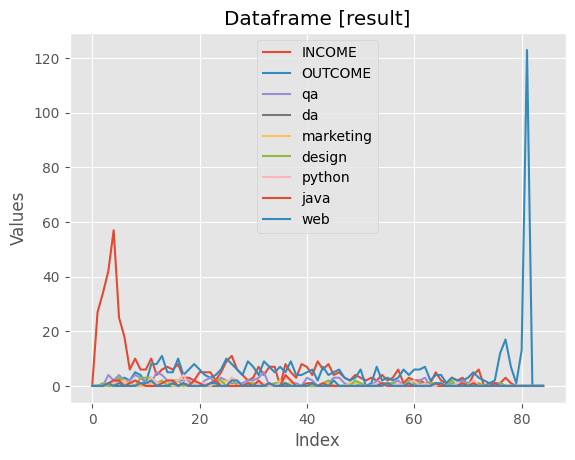

In [50]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data
result.plot(ax=ax)

# Set the title and labels
ax.set_title('Dataframe [result]')
ax.set_xlabel('Index')
ax.set_ylabel('Values')

# Show the plot
plt.show()

In [51]:
# import matplotlib.pyplot as plt
#
# # Create a figure and an axes
# fig, ax = plt.subplots(figsize=(14, 7))
#
# plt.style.use(style='ggplot')
# plt.xticks([])
#
# # Plot the data
# ax.bar(result['time'].astype(str), result['INCOME'], label='INCOME', color='green')
# ax.bar(result['time'].astype(str), result['OUTCOME'], label='OUTCOME', color='red')
#
# # Set the x-axis label
# ax.set_xlabel('Time')
#
# # Set the y-axis label
# ax.set_ylabel('Number of visitors')
#
# # # Add a legend
# ax.legend()
#
# # Show the plot
# plt.show()
